In [20]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
print("Tensorflow version %s" %tf.__version__)

Tensorflow version 2.11.0


In [21]:
#import data

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datadir = '/Users/pc/Desktop/musical instruments'
trainingset = datadir+'/train/'
testset = datadir + '/test/'

batch_size = 32

#train set
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

#image size 224x224x3
train = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

#test set
test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

classnames = [k for k,v in train.class_indices.items()]
print(classnames)
input_shape = (224,224,3)
num_classes = 17


Found 2636 images belonging to 17 classes.
Found 85 images belonging to 17 classes.
['acordian', 'alphorn', 'bagpipes', 'castanets', 'clarinet', 'drums', 'flute', 'guitar', 'harmonica', 'harp', 'piano', 'saxaphone', 'sitar', 'steel drum', 'trombone', 'trumpet', 'violin']


acordian


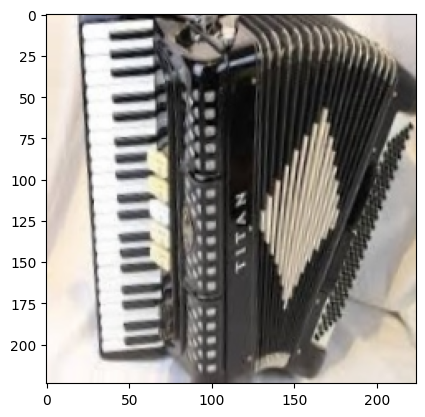

clarinet


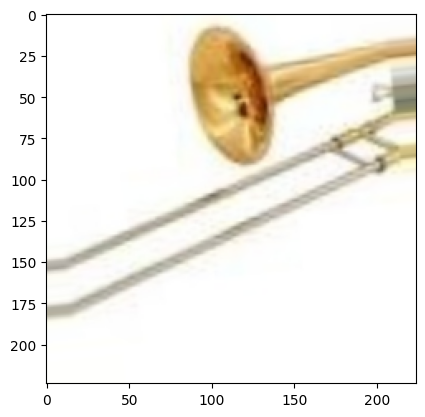

In [31]:

x,y = train.next()


for i in range(0,2):
    image = x[i]
    label = y[i].argmax()
    print(classnames[label])
    plt.imshow(image)
    plt.show()

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 17)


In [34]:
#Alexnet model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

def AlexNet(input_shape, num_classes, regl2 = 0.0001, lr=0.0001):

    model = Sequential()

    # C1 Convolutional Layer 
    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11),\
                     strides=(2,4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C3 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C4 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C5 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)
    
    # D1 Dense Layer
    model.add(Dense(4096, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.5))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D2 Dense Layer
    model.add(Dense(4096, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.5))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D3 Dense Layer
    model.add(Dense(1000,kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.5))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile

    adam = optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model
 
# create the model
model = AlexNet(input_shape,num_classes)
model.summary()

# history of results (set to None when initializing a new mdoel)
history = None


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 107, 54, 96)       34944     
                                                                 
 activation_18 (Activation)  (None, 107, 54, 96)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 53, 27, 96)       0         
 2D)                                                             
                                                                 
 batch_normalization_16 (Bat  (None, 53, 27, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 43, 17, 256)       2973952   
                                                                 
 activation_19 (Activation)  (None, 43, 17, 256)      

In [25]:
#train
history= None

h = model.fit(train, validation_data=test, epochs =  50)

if history is None:
    history = h.history
else:
    history['loss'].extend(h.history['loss'])
    history['accuracy'].extend(h.history['accuracy'])
    history['val_loss'].extend(h.history['val_loss'])
    history['val_accuracy'].extend(h.history['val_accuracy'])

Epoch 1/50
83/83 [==============================] - 139s 2s/step - loss: 3.8889 - accuracy: 0.1722 - val_loss: 3.7918 - val_accuracy: 0.0471
Epoch 2/50
83/83 [==============================] - 127s 2s/step - loss: 3.5891 - accuracy: 0.2288 - val_loss: 3.9304 - val_accuracy: 0.0353
Epoch 3/50
83/83 [==============================] - 127s 2s/step - loss: 3.3390 - accuracy: 0.2864 - val_loss: 4.0613 - val_accuracy: 0.0941
Epoch 4/50
83/83 [==============================] - 127s 2s/step - loss: 3.1466 - accuracy: 0.3338 - val_loss: 3.8418 - val_accuracy: 0.0824
Epoch 5/50
83/83 [==============================] - 127s 2s/step - loss: 3.0296 - accuracy: 0.3615 - val_loss: 2.9894 - val_accuracy: 0.2235
Epoch 6/50
83/83 [==============================] - 127s 2s/step - loss: 2.8774 - accuracy: 0.3998 - val_loss: 2.9934 - val_accuracy: 0.4353
Epoch 7/50
83/83 [==============================] - 123s 1s/step - loss: 2.8195 - accuracy: 0.4097 - val_loss: 2.8149 - val_accuracy: 0.4471
Epoch 8/50
83

In [33]:
#confusion matrix

import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))
  

Found 85 images belonging to 17 classes.


C:\Users\pc\AppData\Local\Temp\ipykernel_15760\151166496.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)


3/3 [==============================] - 1s 210ms/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
alphorn          ->  guitar            	1 	1.18 % 
alphorn          ->  harp              	1 	1.18 % 
alphorn          ->  violin            	1 	1.18 % 
clarinet         ->  flute             	1 	1.18 % 
clarinet         ->  sitar             	1 	1.18 % 
flute            ->  alphorn           	1 	1.18 % 
flute            ->  trombone          	1 	1.18 % 
harmonica        ->  sitar             	1 	1.18 % 
piano            ->  guitar            	1 	1.18 % 
sitar            ->  clarinet          	1 	1.18 % 
steel drum       ->  alphorn           	1 	1.18 % 
trombone         ->  sitar             	1 	1.18 % 
trombone         ->  trumpet           	1 	1.18 % 
trumpet          ->  alphorn           	1 	1.18 % 
trumpet          ->  trombone          	1 	1.18 % 
violin           ->  guitar            	1 	1.18 % 


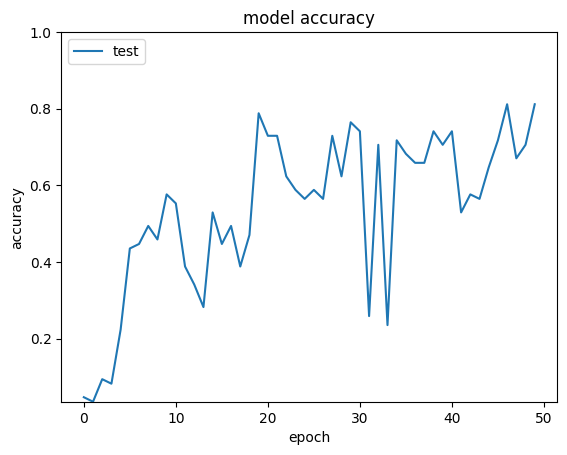

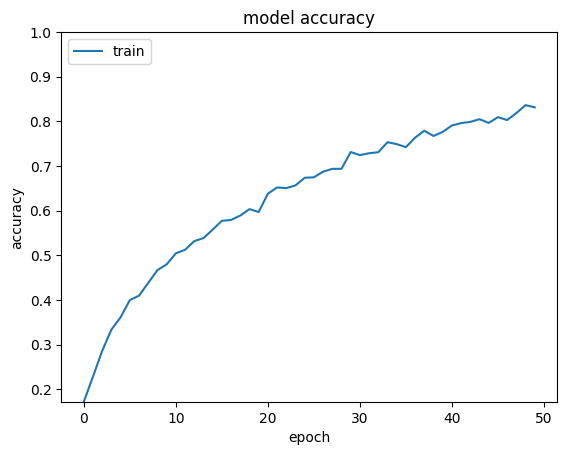

In [40]:
import matplotlib.pyplot as plt

# plot history for accuracy
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(np.min(h.history['val_accuracy']), 1.0)
plt.legend(['test'], loc='upper left')
plt.show()

plt.plot(h.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(np.min(h.history['accuracy']), 1.0)
plt.legend(['train'], loc='upper left')
plt.show()


Hereby we start ensemble model code

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

In [ ]:
#import data

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datadir = '/Users/pc/Desktop/musical instruments'
trainingset = datadir+'/train/'
testset = datadir + '/test/'

batch_size = 32

#train set
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

#image size 224x224x3
train = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

#test set
test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

classnames = [k for k,v in train.class_indices.items()]
print(classnames)
input_shape = (224,224,3)
num_classes = 17
Xtrain=train
Xtest=test
Ytest=classnames
Ytrain=classnames

Found 2636 images belonging to 17 classes.
Found 85 images belonging to 17 classes.
['acordian', 'alphorn', 'bagpipes', 'castanets', 'clarinet', 'drums', 'flute', 'guitar', 'harmonica', 'harp', 'piano', 'saxaphone', 'sitar', 'steel drum', 'trombone', 'trumpet', 'violin']


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPool2D, Input, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

# single model
def CNN(input_shape, num_classes, base_width=16, depth=4):
    
    inputs = Input(input_shape)
    
    image_size = input_shape[0]
    filters = base_width
    kernel_size = 3
    # feature extractor
    for i in range(depth):
        if i == 0:
            x = Conv2D(filters=filters,
                       kernel_size = kernel_size,
                       activation="relu",
                       strides=1,
                       padding="same")(inputs)
        else:
            x = Conv2D(filters=filters,
                       kernel_size = kernel_size,
                       activation="relu",
                       strides=1,
                       padding="same")(x)
        x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid")(x)
        filters *= 2
    
    x = Flatten()(x) 
    x = Dropout(0.4)(x)
    
    outputs = Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# ensemble model
def Ensemble(ens_dim, input_shape, num_classes, base_width=16, depth=4):
  inputs = Input(shape=input_shape)
  
  learners = [CNN(input_shape,
                  num_classes,
                  base_width,
                  depth) for _ in range(ens_dim)]
  
  outputs = [learners[i](inputs) for i in range(ens_dim)]
  
  ensemble_model = Model(inputs, outputs, name="ensemble_model")
  optimizer = 'adam'
  # an independent loss for each model
  losses = ["categorical_crossentropy" for _ in range(ens_dim)]
  ensemble_model.compile(loss=losses, optimizer=optimizer, metrics=['accuracy'])
  return ensemble_model


# create the ensemble model
ens_dim = 3
model = Ensemble(ens_dim, input_shape, num_classes)
model.summary()

# single model summary
model.get_layer(index=-1).summary()

In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def test_accuracy(model, history):
    # accuracy
    ind_test_acc = []
    for key in history.history.keys():
      if ("val" in key) and ("accuracy" in key):
        ind_test_acc.append(history.history[key][-1])
    print("Single models test accuracy: ", ind_test_acc)

    # ensemble test accuracy
    preds = np.array(model.predict(Xtest))
    # average over the ensemble
    preds_ens = np.mean(preds, axis=0)
    ens_test_acc = accuracy_score(np.argmax(test, axis=-1), np.argmax(preds_ens, axis=-1))
    print("Ensemble test accuracy: ", ens_test_acc)

    return ind_test_acc, ens_test_acc


history = tf.keras.callbacks.History()
ind_test_accuracy = []
ens_test_accuracy = []

In [ ]:
epochs = 25
Xtrain=train
Xtest=test
Ytest=classnames
Ytrain=classnames

model.fit(Xtrain, batch_size=32, epochs=25, callbacks=[history], validation_data = Xtest)

iacc, eacc = test_accuracy(model, history)
ind_test_accuracy.append(iacc)
ens_test_accuracy.append(eacc)


Epoch 1/25
83/83 [==============================] - 82s 986ms/step - loss: 4.4161 - model_loss: 1.4772 - model_1_loss: 1.4902 - model_2_loss: 1.4487 - model_accuracy: 0.5467 - model_1_accuracy: 0.5463 - model_2_accuracy: 0.5531 - val_loss: 2.6322 - val_model_loss: 0.9446 - val_model_1_loss: 0.7991 - val_model_2_loss: 0.8885 - val_model_accuracy: 0.7412 - val_model_1_accuracy: 0.7294 - val_model_2_accuracy: 0.7176
Epoch 2/25
83/83 [==============================] - 87s 1s/step - loss: 4.1540 - model_loss: 1.3689 - model_1_loss: 1.4293 - model_2_loss: 1.3558 - model_accuracy: 0.5819 - model_1_accuracy: 0.5596 - model_2_accuracy: 0.5706 - val_loss: 2.4074 - val_model_loss: 0.8293 - val_model_1_loss: 0.7009 - val_model_2_loss: 0.8772 - val_model_accuracy: 0.7529 - val_model_1_accuracy: 0.7765 - val_model_2_accuracy: 0.6941
Epoch 3/25
83/83 [==============================] - 87s 1s/step - loss: 3.8739 - model_loss: 1.2993 - model_1_loss: 1.3189 - model_2_loss: 1.2556 - model_accuracy: 0.589

MemoryError: ignored